# Deep Learning Training Model for NLP

In [114]:
import pandas as pd
import numpy as np
import pickle
import itertools
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from preprocessing import *
from sklearn.metrics import confusion_matrix, accuracy_score

### Import csv file & preprocessing the text

In [5]:
total_df = pd.read_csv("dataset/train.csv", encoding="ISO-8859-1")
total_df.columns = ["ItemID", "sentiment", "text"]
total_df.drop(["ItemID"], axis=1, inplace=True)
total_df.dropna(inplace=True)
total_df["text"] = total_df["text"].apply(clean_text)
total_df["sentiment"] = total_df["sentiment"].apply(float)
total_df.sentiment = total_df.sentiment.replace(1.0, "positive")
total_df.sentiment = total_df.sentiment.replace(0.0, "negative")

In [6]:
total_df.head(10)

,sentiment,text
0,negative,sad apl friend
1,negative,miss new moon trailer
2,positive,omg alreadi
3,negative,omgaga im sooo im gunna cri thi dentist sinc w...
4,negative,think mi bf cheat
5,negative,worri much
6,positive,juuuuuuuuuuuuuuuuussssst chillin
7,negative,sunni work tomorrow tv tonight
8,positive,hand uniform today miss alreadi
9,positive,hmmmm wonder number


### Split train and test set

In [7]:
train_df, test_df = train_test_split(total_df, test_size=0.2, random_state=42)
print("training set in the length of {}".format(len(train_df)))
print("testing set in the length of {}".format(len(test_df)))

training set in the length of 79991
testing set in the length of 19998


In [8]:
#get the list of text and sentiment in the training set
train_text = train_df.text.tolist()
train_sentiment = train_df.sentiment.tolist()

#get the list of text and sentiment in the testing set
test_text = test_df.text.tolist()
test_sentiment = test_df.sentiment.tolist()

### Train word2vec model

In [9]:
# train a model by yourself
train_text_w2v = [i.split() for i in train_text]
w2v = Word2Vec(train_text_w2v, size=200, window=5, min_count=5, workers=8)

# save model
w2v.save("model.w2v")

In [ ]:
# Too Slow on laptop
# use a pretrained model for the unorganized text messages
# import gensim.downloader as api
# w2v = api.load("glove-twitter-25")
# print(w2v.most_similar("ok"))

[=====---------------------------------------------] 10.7% 11.2/104.8MB downloaded

In [14]:
# tokenize training text
t = Tokenizer()
t.fit_on_texts(train_text)
n_v = len(t.word_index) + 1

# save model
pickle.dump(t, open("tokenizer.pkl", "wb"), protocol=0)

In [15]:
# make it into pad sequence
x_train = pad_sequences(t.texts_to_sequences(train_text), maxlen=100)
x_test = pad_sequences(t.texts_to_sequences(test_text), maxlen=100)

In [16]:
# Normalize encode sentiment information (classification)
e = LabelEncoder()
e.fit(train_sentiment)

# save model
pickle.dump(e, open("encoder.pkl", "wb"), protocol=0)

LabelEncoder()

In [17]:
y_train = e.transform(train_sentiment).reshape(-1, 1)
y_test = e.transform(test_sentiment).reshape(-1, 1)

In [18]:
# Word embedding
embed_matrix = np.zeros((n_v, 200))
for i, j in t.word_index.items():
    if i in w2v.wv:
        embed_matrix[j] = w2v.wv[i]

embedding_layer = Embedding(
    n_v, 200, weights=[embed_matrix], input_length=100, trainable=False
)

### Create and train Sequential Model

In [19]:
def create_model(layer):
    '''create a Sequence model with a layer
    '''
    model = Sequential()
    model.add(layer)
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation="relu"))
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])
    return model

# Trace callbacks to know where we are
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", patience=5, cooldown=0),
    EarlyStopping(monitor="val_mse", min_delta=1e-4, patience=5),
]

model = create_model(embedding_layer)

# save the information of model fitting in 'history'
history = model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=50,
    validation_split=0.1,
    verbose=1,
    callbacks=callbacks,
)

# save model
model.save("model.h5")

Train on 71991 samples, validate on 8000 samples
Epoch 1/50
71991/71991 [==============================] - 81s 1ms/step - loss: 0.2152 - mse: 0.2152 - val_loss: 0.1913 - val_mse: 0.1913
Epoch 2/50


/Users/haihaoguo/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_mse,loss,mse,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


71991/71991 [==============================] - 82s 1ms/step - loss: 0.1985 - mse: 0.1985 - val_loss: 0.1849 - val_mse: 0.1849
Epoch 3/50
71991/71991 [==============================] - 87s 1ms/step - loss: 0.1943 - mse: 0.1943 - val_loss: 0.1846 - val_mse: 0.1846
Epoch 4/50
71991/71991 [==============================] - 84s 1ms/step - loss: 0.1917 - mse: 0.1917 - val_loss: 0.1824 - val_mse: 0.1824
Epoch 5/50
71991/71991 [==============================] - 82s 1ms/step - loss: 0.1896 - mse: 0.1896 - val_loss: 0.1822 - val_mse: 0.1822
Epoch 6/50
71991/71991 [==============================] - 80s 1ms/step - loss: 0.1886 - mse: 0.1886 - val_loss: 0.1804 - val_mse: 0.1804
Epoch 7/50
71991/71991 [==============================] - 85s 1ms/step - loss: 0.1876 - mse: 0.1876 - val_loss: 0.1801 - val_mse: 0.1801
Epoch 8/50
71991/71991 [==============================] - 85s 1ms/step - loss: 0.1865 - mse: 0.1865 - val_loss: 0.1797 - val_mse: 0.1797
Epoch 9/50
71991/71991 [============================

### Evaluate and plot the change of accuracy and loss through time

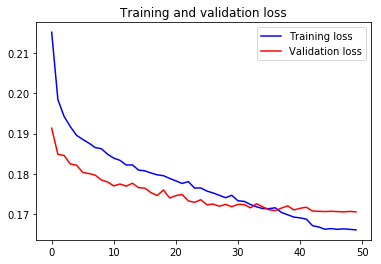

In [25]:
# Comparing the Training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(loss))
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Confusion Matrix
we could see from the graph that the training loss and validation loss are converging, that means there is a high probability we got a perfect fitting.

Next we are going to draw the confusion matrix

In [127]:
# We choose 0.57 as a threshold here based on several trying with the model
def get_sentiment(score):
        return 'negative' if score < 0.57 else 'positive'

In [128]:
y_pred_1d = []
y_test_1d = test_sentiment
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [get_sentiment(score) for score in scores]

19998/19998 [==============================] - 6s 294us/step


[[0.72411429 0.27588571]
 [0.26858108 0.73141892]]


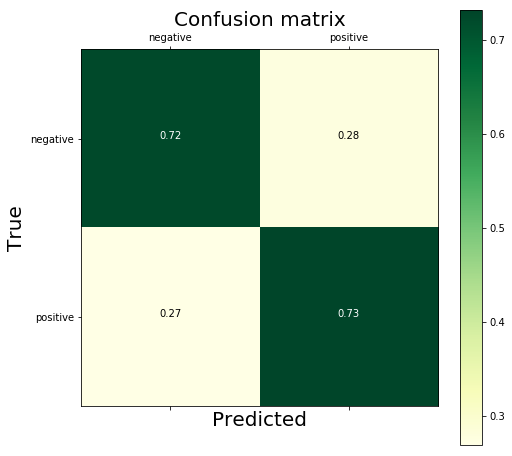

In [129]:
labels = ['negative', 'positive']
cm = confusion_matrix(y_test_1d, y_pred_1d, labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
thresh = cm.max() / 2.
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix', fontsize=20)
ax.set_xticklabels([''] + labels, fontsize=10)
ax.set_yticklabels([''] + labels, fontsize=10)
plt.imshow(cm, cmap=plt.cm.YlGn)
plt.colorbar()
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.rcParams["figure.figsize"] = (8 ,8)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

In [130]:
# Get the overall accuracy score
accuracy_score(y_test_1d, y_pred_1d)

0.7282228222822282